<a href="https://colab.research.google.com/github/shiri9/Federated-Machine-Learning/blob/main/Copy_of_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q flwr[simulation] torch torchvision matplotlib;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 10.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 34.8 MB/s eta 0:00:00


In [2]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
#from torchvision.datasets import MNIST
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset, random_split

import flwr as fl
from flwr.common import Metrics
from flwr.common.typing import NDArrays, Scalar

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder


#reading training csv file from google drive
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kdd_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kdd_test.csv')

#creating copies of datasets
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

#Encoding categories in 0-Normal, 1-DoS, 2-Probe, 3-R2L, 4-U2R
df1_train_labels = df_train_copy['labels']
df1_train_labels_in_numbers = df1_train_labels.replace({ 'normal' : 0, 'neptune' : 1,'land' : 1, 'back': 1, 'teardrop': 1, 'pod': 1, 'smurf' : 1,
                                                     'ipsweep' : 2, 'nmap' : 2, 'portsweep' : 2, 'satan' : 2,
                                                     'phf': 3, 'multihop': 3, 'warezclient': 3,'warezmaster': 3, 'spy': 3, 'ftp_write' : 3,
                                                     'guess_passwd': 3,'imap': 3,
                                                     'buffer_overflow': 4, 'loadmodule': 4,'perl': 4,  'rootkit': 4 })
#replacing the string output clsses by numbers
df_train_copy['labels'] = df1_train_labels_in_numbers

#Encoding categories in 0-Normal, 1-DoS, 2-Probe, 3-R2L, 4-U2R
df1_test_labels = df_test_copy['labels']
df1_test_labels_in_numbers = df1_test_labels.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1,
                                                      'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1,
                                                     'ipsweep' : 2, 'nmap' : 2, 'portsweep' : 2, 'satan' : 2, 'mscan' : 2,'saint' : 2,
                                                     'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3, 'warezclient': 3,
                                                       'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,
                                                       'xsnoop': 3,'httptunnel': 3,
                                                     'buffer_overflow': 4, 'loadmodule': 4,'perl': 4,  'rootkit': 4, 'ps': 4,'xterm': 4 })
#replacing the string output clsses by numbers
df_test_copy['labels'] = df1_test_labels_in_numbers

#Transform categorical features into numbers using LabelEncoder() from train dataset
dft = df_train_copy.apply(LabelEncoder().fit_transform)
df_train_copy = dft

#Transform categorical features into numbers using LabelEncoder() from test dataset
dftt = df_test_copy.apply(LabelEncoder().fit_transform)
df_test_copy = dftt

# Dropping the column "num_outbound_cmds" from train and test datasets
df_train_copy = df_train_copy.drop('num_outbound_cmds', axis=1)
df_test_copy = df_test_copy.drop('num_outbound_cmds', axis=1)

from sklearn.preprocessing import MinMaxScaler

# Select the columns to be normalized (assuming they are numerical features)
numerical_columns = ['duration', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
                     'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                     'dst_host_same_src_port_rate','dst_host_serror_rate', 'dst_host_srv_serror_rate', 'rerror_rate',
                     'srv_rerror_rate','diff_srv_rate', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate',
                     'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','hot','num_compromised','num_root',]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the selected columns
scaler.fit(df_train_copy[numerical_columns])

# Transform the selected columns with the scaler
df_train_copy[numerical_columns] = scaler.transform(df_train_copy[numerical_columns])

# Select the columns to be normalized (assuming they are numerical features)
numerical_columns = ['duration', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
                     'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                     'dst_host_same_src_port_rate','dst_host_serror_rate', 'dst_host_srv_serror_rate', 'rerror_rate',
                     'srv_rerror_rate','diff_srv_rate', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate',
                     'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','hot','num_compromised','num_root',]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the selected columns
scaler.fit(df_test_copy[numerical_columns])

# Transform the selected columns with the scaler
df_test_copy[numerical_columns] = scaler.transform(df_test_copy[numerical_columns])

In [5]:
df_train_copy.shape

(125973, 41)

In [5]:
# Determine the number of partitions
num_partitions = 10

# Split your DataFrame into 10 partitions
partition_size = len(df_train_copy) // num_partitions
data_partitions = []

for i in range(num_partitions):
    start_index = i * partition_size
    end_index = (i + 1) * partition_size if i < num_partitions - 1 else len(df_train_copy)
    partition = df_train_copy.iloc[start_index:end_index]
    data_partitions.append(partition)

# Create DataLoaders for each partition with validation datasets
batch_size = 32  # Set your desired batch size
dataloaders = []
val_loaders = []

for partition in data_partitions:
    # Split each partition into training and validation subsets (90% train, 10% validation)
    len_partition = len(partition)
    len_train = int(0.9 * len_partition)
    len_val = len_partition - len_train

    train_partition, val_partition = random_split(partition, [len_train, len_val], generator=torch.Generator().manual_seed(42))

    # Prepare training DataLoader
    train_features = train_partition.dataset.drop(columns=['labels'])  # Replace 'labels' with your label column name
    train_labels = train_partition.dataset['labels']  # Replace 'labels' with your label column name

    train_features_tensor = torch.Tensor(train_features.values)
    train_labels_tensor = torch.Tensor(train_labels.values)

    train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # Prepare validation DataLoader
    val_features = val_partition.dataset.drop(columns=['labels'])  # Replace 'labels' with your label column name
    val_labels = val_partition.dataset['labels']  # Replace 'labels' with your label column name

    val_features_tensor = torch.Tensor(val_features.values)
    val_labels_tensor = torch.Tensor(val_labels.values)

    val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    dataloaders.append(train_dataloader)
    val_loaders.append(val_dataloader)

# Create a DataLoader for the test dataset
test_features = df_test_copy.drop(columns=['labels'])  # Replace 'labels' with your label column name
test_labels = df_test_copy['labels']  # Replace 'labels' with your label column name

test_features_tensor = torch.Tensor(test_features.values)
test_labels_tensor = torch.Tensor(test_labels.values)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Now 'dataloaders' is a list of training DataLoaders, 'val_loaders' is a list of validation DataLoaders,
# and 'test_dataloader' is the DataLoader for the test dataset.
# Each partition has its own training and validation DataLoader.
# You can use these for federated learning, and validation during training, and testing.


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define your layers here
        self.fc1 = nn.Linear(40, 128)  # 40 input features, 128 hidden units
        self.fc2 = nn.Linear(128, 64)  # 128 hidden units, 64 hidden units
        self.fc3 = nn.Linear(64, 5)   # 64 hidden units, 5 output classes (assuming you have 5 classes)

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    lrate = 0.001
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lrate)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for data, labels in trainloader:
            data, labels = data.to(DEVICE), labels.long().to(DEVICE)
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        epoch_loss /= len(trainloader)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

# def test(net, testloader):
#     """Evaluate the network on the entire test set."""
#     criterion = torch.nn.CrossEntropyLoss()
#     correct, total, loss = 0, 0, 0.0
#     net.eval()
#     with torch.no_grad():
#         for data, labels in testloader:
#             data, labels = data.to(DEVICE), labels.long().to(DEVICE)
#             outputs = net(data)
#             loss += criterion(outputs, labels).item()
#             total += labels.size(0)
#             _, predicted = torch.max(outputs.data, 1)
#             correct += (predicted == labels).sum().item()
#     loss /= len(testloader)
#     accuracy = correct / total
#     return loss, accuracy

#added
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    true_labels = []  # To store true labels
    predicted_labels = []  # To store predicted labels

    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.to(DEVICE), labels.long().to(DEVICE)
            outputs = net(data)
            loss += criterion(outputs, labels).item()
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())  # Store true labels
            predicted_labels.extend(predicted.cpu().numpy())  # Store predicted labels

    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy, true_labels, predicted_labels


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score  # Import these functions

net = Net().to(DEVICE)
num_clients = 10

for epoch in range(10):
    print(f"Training for epoch {epoch+1}")
    for i in range(num_clients):
        dataloader = dataloaders[i]
        valloader = val_loaders[i]
        train(net, dataloader, 1)
        loss, accuracy, true_labels, predicted_labels = test(net, valloader)
        print(f"Client {i+1} Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

    print(f"End of epoch {epoch+1}")

# After all epochs, test the model with the testloader
loss, accuracy, true_labels, predicted_labels = test(net, test_dataloader)

# Calculate macro precision, recall, and F1-score
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Final test set performance:")
print(f"\tLoss: {loss}")
print(f"\tAccuracy: {accuracy}")
print(f"\tMacro Precision: {macro_precision}")
print(f"\tMacro Recall: {macro_recall}")
print(f"\tMacro F1-Score: {macro_f1}")

# # After all epochs, test the model with the testloader
# loss, accuracy = test(net, test_dataloader)
# print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Training for epoch 1
Client 1 Epoch 1: validation loss 0.08433405993279391, accuracy 0.975867269984917
Client 2 Epoch 1: validation loss 0.056471193424392926, accuracy 0.9822179884099389
Client 3 Epoch 1: validation loss 0.04320862085311313, accuracy 0.9843613558783837
Client 4 Epoch 1: validation loss 0.03914134725656474, accuracy 0.9889656267365246
Client 5 Epoch 1: validation loss 0.03470503062138784, accuracy 0.9903945383821545
Client 6 Epoch 1: validation loss 0.031065985535006724, accuracy 0.9906326903230928
Client 7 Epoch 1: validation loss 0.027805231771459046, accuracy 0.9921409859490354
Client 8 Epoch 1: validation loss 0.030364102053242973, accuracy 0.9894419306184012
Client 9 Epoch 1: validation loss 0.03184381249837334, accuracy 0.988489322854648
Client 10 Epoch 1: validation loss 0.024051925345739262, accuracy 0.9935714285714285
End of epoch 1
Training for epoch 2
Client 1 Epoch 2: validation loss 0.026515513093085624, accuracy 0.9919822179884099
Client 2 Epoch 2: validat

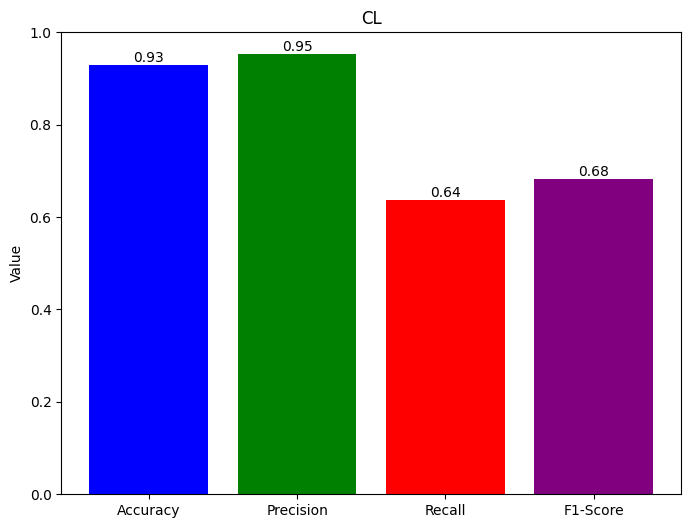

In [22]:
import matplotlib.pyplot as plt

# Define the metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [0.9290720369056068, 0.9528672538631785, 0.6372885898925746, 0.6815106316114095]

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('CL')
plt.ylabel('Value')
plt.ylim(0, 1)  # Set the y-axis limit to match the range of values (0 to 1)

# Display the values on top of the bars
for metric, value in zip(metrics, values):
    plt.text(metric, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()


In [23]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [24]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        #added
        self.true_labels = []  # To store true labels
        self.predicted_labels = []  # To store predicted labels

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        #added
        loss, accuracy, y_true, y_pred = test(self.net, self.valloader)
        self.true_labels.extend(y_true)
        self.predicted_labels.extend(y_pred)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

        # loss, accuracy = test(self.net, self.valloader)
        # return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [25]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = dataloaders[int(cid)]
    valloader = val_loaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [26]:
# def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
#     # Multiply accuracy of each client by number of examples used
#     accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
#     examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    #return {"accuracy": sum(accuracies) / sum(examples)}
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Calculate macro precision, recall, and F1-score
    macro_precision = precision_score(true_labels, predicted_labels, average='macro')
    macro_recall = recall_score(true_labels, predicted_labels, average='macro')
    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Aggregate and return custom metrics (weighted average, macro precision, recall, and F1-score)
    return {
        "accuracy": sum(accuracies) / sum(examples),
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1
    }

In [29]:
NUM_CLIENTS = 10

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available

)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-22 11:16:46,801 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-22 11:16:52,842	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-22 11:16:57,203 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7797222606.0, 'object_store_memory': 3898611302.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7797222606.0, 'object_store_memory': 3898611302.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-09-22 11:16:57,209 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-22 11:16:57,212 | app.py:224 | Flower VCE: Resources for each Virtual Cl

History (loss, distributed):
	round 1: 0.09159230794332127
	round 2: 0.05286472621255644
	round 3: 0.04118019736033325
	round 4: 0.0367945405180527
	round 5: 0.03308132207102372
	round 6: 0.031021253555096558
	round 7: 0.029601871677919077
	round 8: 0.028287304267749665
	round 9: 0.027030311040121185
	round 10: 0.02562525741014369

In [32]:
NUM_CLIENTS = 10

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function

)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-22 11:32:24,012 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-22 11:32:29,705	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-22 11:32:34,598 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3899035238.0, 'memory': 7798070478.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3899035238.0, 'memory': 7798070478.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-09-22 11:32:34,606 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-22 11:32:34,610 | app.py:224 | Flower VCE: Resources for each Virtual Cl

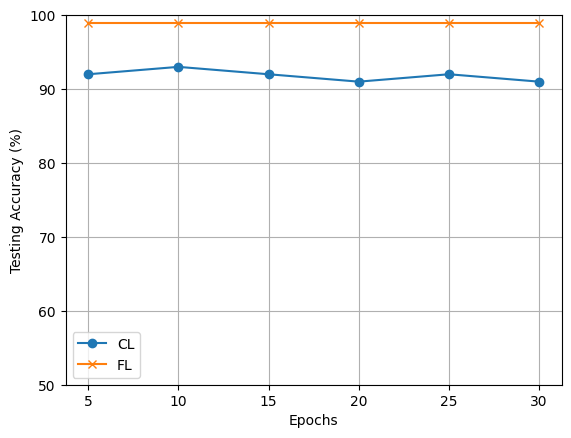

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
epochs = [5, 10, 15, 20, 25, 30]
cl_accuracy = [92, 93, 92, 91, 92, 91]
fl_accuracy = [99, 99, 99, 99, 99, 99]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot CL accuracy with lines and markers at epoch points
ax.plot(epochs, cl_accuracy, marker='o', linestyle='-', label='CL')

# Plot FL accuracy with lines and markers at epoch points
ax.plot(epochs, fl_accuracy, marker='x', linestyle='-', label='FL')

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Testing Accuracy (%)')
ax.grid(True)

# Add a legend
ax.legend()

# Set y-axis limits between 50 and 100
ax.set_ylim(50, 100)

# Set x-axis ticks to only display specified epoch values
ax.set_xticks(epochs)

# Save the plot as a PNG image
plt.savefig('acc_vs_epochs.png')

#


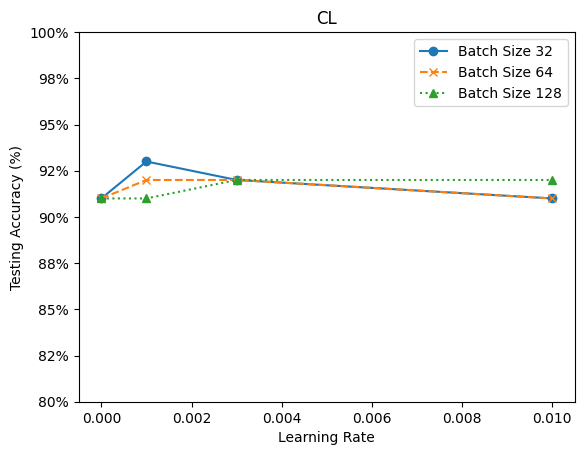

In [64]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Data
selected_learning_rates = [0, 0.001, 0.003, 0.01]
batch_sizes = [32, 64, 128]

cl_accuracy = {
    32: [0.91, 0.93, 0.92, 0.91],
    64: [0.91, 0.92, 0.92, 0.91],
    128: [0.91, 0.91, 0.92, 0.92]
}

# Create a figure and axis
fig, ax = plt.subplots()

# Set the line styles and markers for each batch size
line_styles = ['-', '--', ':']
markers = ['o', 'x', '^']

# Plot CL accuracy for each batch size
for batch_size in batch_sizes:
    cl_accuracies = [cl_accuracy[batch_size][selected_learning_rates.index(lr)] * 100 for lr in selected_learning_rates]  # Convert to percentage
    ax.plot(selected_learning_rates, cl_accuracies, linestyle=line_styles[batch_sizes.index(batch_size)], marker=markers[batch_sizes.index(batch_size)], label=f'Batch Size {batch_size}')

# Set labels and title
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Testing Accuracy (%)')
ax.set_title('CL')
ax.legend()

# Set y-axis limits between 90% and 100%
ax.set_ylim(80, 100)

# Format y-axis tick labels as percentages
def percentage_formatter(x, pos):
    return f'{x:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Save the plot as a PNG image
plt.savefig('CL-batch_lear.png')

# Show the plot
plt.show()


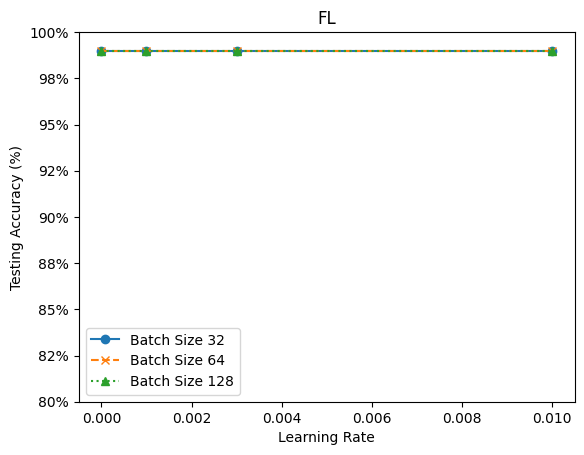

In [72]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Data
selected_learning_rates = [0, 0.001, 0.003, 0.01]
batch_sizes = [32, 64, 128]

fl_accuracy = {
    32: [0.99, 0.99, 0.99, 0.99],
    64: [0.99, 0.99, 0.99, 0.99],
    128: [0.99, 0.99, 0.99, 0.99]
}

# Create a figure and axis
fig, ax = plt.subplots()

# Set the line styles and markers for each batch size
line_styles = ['-', '--', ':']
markers = ['o', 'x', '^']

# Plot CL accuracy for each batch size
for batch_size in batch_sizes:
    fl_accuracies = [fl_accuracy[batch_size][selected_learning_rates.index(lr)] * 100 for lr in selected_learning_rates]  # Convert to percentage
    ax.plot(selected_learning_rates, fl_accuracies, linestyle=line_styles[batch_sizes.index(batch_size)], marker=markers[batch_sizes.index(batch_size)], label=f'Batch Size {batch_size}')

# Set labels and title
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Testing Accuracy (%)')
ax.set_title('FL')
ax.legend()

# Set y-axis limits between 90% and 100%
ax.set_ylim(80, 100)

# Format y-axis tick labels as percentages
def percentage_formatter(x, pos):
    return f'{x:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Save the plot as a PNG image
plt.savefig('FL-batch_lear.png')

# Show the plot
plt.show()



In [73]:
from google.colab import files

# Download the plot
files.download('FL-batch_lear.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

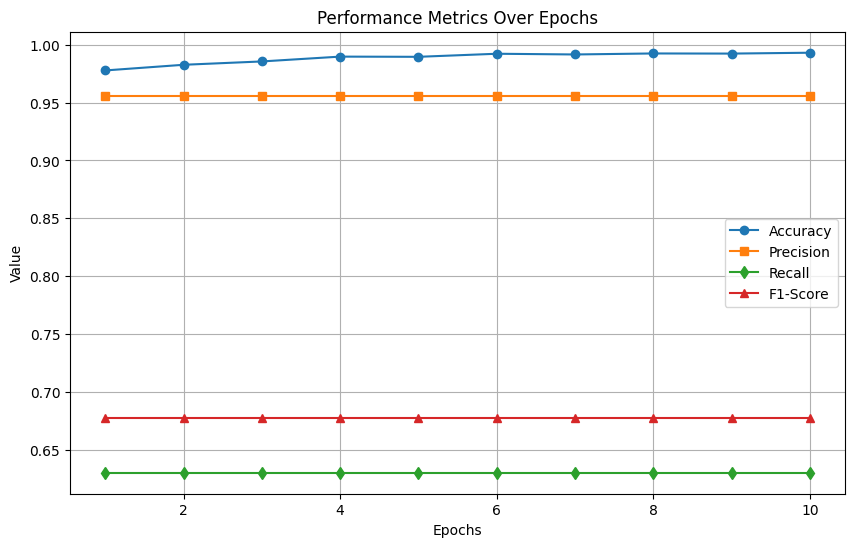

In [37]:
import matplotlib.pyplot as plt

data = {
    'accuracy': [(1, 0.9778528750231538), (2, 0.9827419226800033), (3, 0.985632164876747), (4, 0.9898076072534278), (5, 0.9896324521711518), (6, 0.9922842475721733), (7, 0.991664682067159), (8, 0.9925382233865206), (9, 0.9924267682781615), (10, 0.9931732763280751)],
    'macro_precision': [(1, 0.955695046171791), (2, 0.955695046171791), (3, 0.955695046171791), (4, 0.955695046171791), (5, 0.955695046171791), (6, 0.955695046171791), (7, 0.955695046171791), (8, 0.955695046171791), (9, 0.955695046171791), (10, 0.955695046171791)],
    'macro_recall': [(1, 0.6300334838223873), (2, 0.6300334838223873), (3, 0.6300334838223873), (4, 0.6300334838223873), (5, 0.6300334838223873), (6, 0.6300334838223873), (7, 0.6300334838223873), (8, 0.6300334838223873), (9, 0.6300334838223873), (10, 0.6300334838223873)],
    'macro_f1': [(1, 0.6775570205457274), (2, 0.6775570205457274), (3, 0.6775570205457274), (4, 0.6775570205457274), (5, 0.6775570205457274), (6, 0.6775570205457274), (7, 0.6775570205457274), (8, 0.6775570205457274), (9, 0.6775570205457274), (10, 0.6775570205457274)]
}

# Extract the data for plotting
epochs = [epoch for epoch, _ in data['accuracy']]
accuracy_values = [value for _, value in data['accuracy']]
precision_values = [value for _, value in data['macro_precision']]
recall_values = [value for _, value in data['macro_recall']]
f1_values = [value for _, value in data['macro_f1']]

# Create the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_values, marker='o', label='Accuracy')
plt.plot(epochs, precision_values, marker='s', label='Precision')
plt.plot(epochs, recall_values, marker='d', label='Recall')
plt.plot(epochs, f1_values, marker='^', label='F1-Score')

plt.title('Performance Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

plt.show()


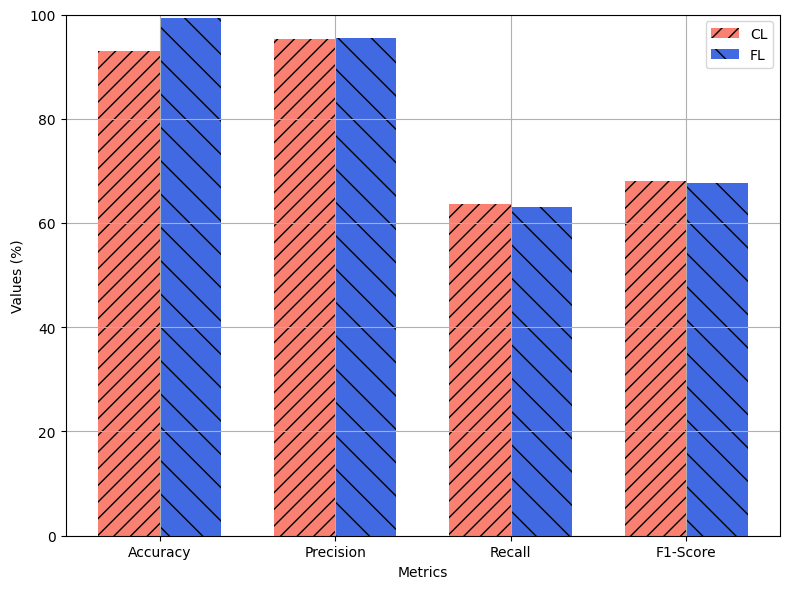

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Define the FL and CL values as percentages (multiply by 100)
fl_values = [0.9931732763280751, 0.955695046171791, 0.6300334838223873, 0.6775570205457274]
cl_values = [0.9290720369056068, 0.9528672538631785, 0.6372885898925746, 0.6815106316114095]

fl_values_percentage = [value * 100 for value in fl_values]
cl_values_percentage = [value * 100 for value in cl_values]

# Create a bar graph with gradient bars
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(x - width/2, cl_values_percentage, width, label='CL', color='salmon', hatch='//')
bar2 = ax.bar(x + width/2, fl_values_percentage, width, label='FL', color='royalblue', hatch='\\')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values (%)')  # Set the y-axis label to indicate percentages

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.ylim(0, 100)  # Set the y-axis limit to the range [0, 100] for percentages
plt.tight_layout()

plt.grid()

# Save the plot as a PNG image
plt.savefig('model_comp.png')

# Show the graph
plt.show()


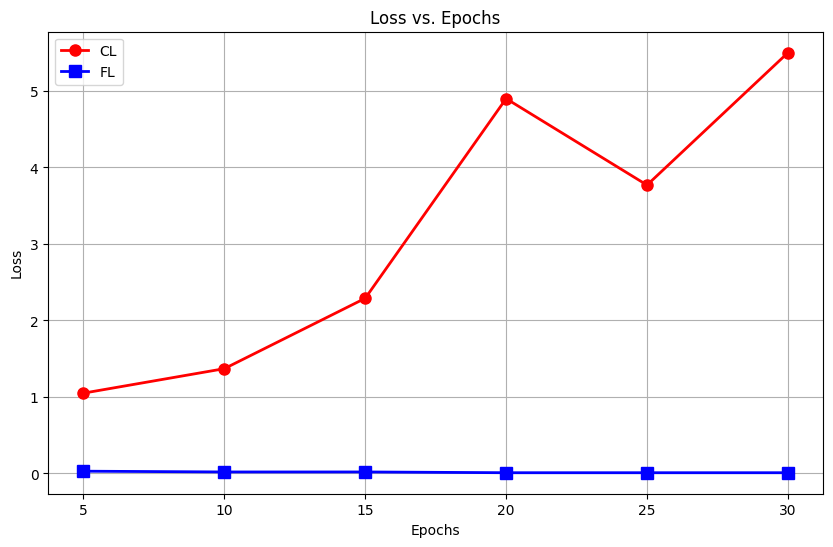

In [21]:
import matplotlib.pyplot as plt

# Data
epochs = [5, 10, 15, 20, 25, 30]
cl_loss = [1.05, 1.37, 2.29, 4.9, 3.77, 5.5]
fl_loss = [0.03, 0.02, 0.02, 0.01, 0.01, 0.01]

# Create the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, cl_loss, marker='o', label='CL', color='red', linestyle='-', linewidth=2, markersize=8)
plt.plot(epochs, fl_loss, marker='s', label='FL', color='blue', linestyle='-', linewidth=2, markersize=8)

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Show the graph
plt.grid(True)
plt.show()


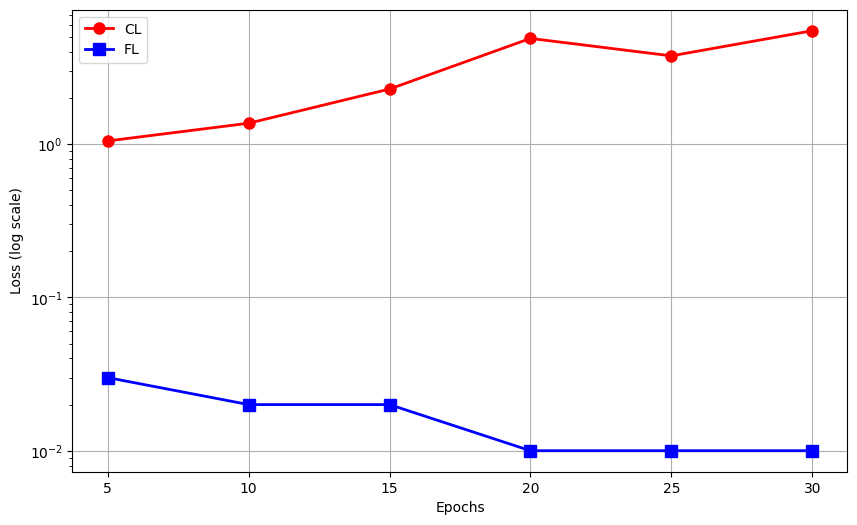

In [24]:
import matplotlib.pyplot as plt

# Data
epochs = [5, 10, 15, 20, 25, 30]
cl_loss = [1.05, 1.37, 2.29, 4.9, 3.77, 5.5]
fl_loss = [0.03, 0.02, 0.02, 0.01, 0.01, 0.01]

# Create the graph with a logarithmic y-axis
plt.figure(figsize=(10, 6))
plt.semilogy(epochs, cl_loss, marker='o', label='CL', color='red', linestyle='-', linewidth=2, markersize=8)
plt.semilogy(epochs, fl_loss, marker='s', label='FL', color='blue', linestyle='-', linewidth=2, markersize=8)

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.legend()

# Show the graph
plt.grid(True)

# Save the plot as a PNG image
plt.savefig('loss.png')

plt.show()


In [27]:
from google.colab import files

# Download the plot
files.download('model_comp.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>